In [230]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
import numpy as np
import torchvision.transforms as T
import torch
from torch.utils.data import Dataset
import cv2
import os
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from albumentations.core.transforms_interface import ImageOnlyTransform

In [231]:
train_dataset_path = '../dataset/handwritten_math_symbols/train/'
eval_dataset_path = '../dataset/handwritten_math_symbols/eval/'
test_dataset_path = '../data/server_uploaded/test/'
crohme_dataset_path = '../dataset/crohm_symbols/'

In [590]:
class Erosin(ImageOnlyTransform):
    def apply(self, img, **params):
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 6, 2)))
        img = cv2.erode(img, kernel, iterations=1)
        return img
    
class Dilation(ImageOnlyTransform):
    def apply(self, img, **params):
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(3, 3, 2)))
        print(kernel)
        img = cv2.dilate(img, kernel, iterations=1)
        return img
    
class ToBlackAndWhite(ImageOnlyTransform):
    def apply(self, img, **params):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img
    
class Thresholding(ImageOnlyTransform):
    def __init__(self, threshold=127, always_apply=False, p=0.5):
        super(Thresholding, self).__init__(always_apply, p)
        self.threshold = threshold
        
    def apply(self, img, **params):
        ret, image = cv2.threshold(img, self.threshold, 255, 0)
        return image
    
class Skeletonize(ImageOnlyTransform):
    def __init__(self, conv_shape=3,invert=True, always_apply=False, p=0.5):
        super(Skeletonize, self).__init__(always_apply, p)
        self.invert = invert
        self.element = cv2.getStructuringElement(cv2.MORPH_CROSS, (conv_shape, conv_shape))
        
    def apply(self, img, **params):
        if self.invert:
            img = 255 - img
        skel = np.zeros(img.shape, np.uint8)
        count = 0
        while True:
            open = cv2.morphologyEx(img, cv2.MORPH_OPEN, self.element)
            temp = cv2.subtract(img, open)
            eroded = cv2.erode(img, self.element)
            skel = cv2.bitwise_or(skel, temp)
            img = eroded.copy()
            if cv2.countNonZero(img)==0:
                break 
        return skel

In [457]:
model_input_shape = (32, 32)
train_dataset_transform = A.Compose([
    ToBlackAndWhite(p=1),
    A.Resize(width=100, height=100),
    A.Perspective(
        scale=(0.06, 0.10),
        p=0.5,
        fit_output=True,
        pad_val=(255.0),
    ),
    A.Rotate(limit=20, p=0.5, value=(255.0), border_mode=cv2.BORDER_CONSTANT),
    A.Resize(width=model_input_shape[0], height=model_input_shape[1]),
    A.PadIfNeeded(
        min_width=model_input_shape[0]+6,
        min_height=model_input_shape[1]+6,
        value=(255.0),
        border_mode=cv2.BORDER_CONSTANT,
        p=1
    ),
    A.RandomCrop(model_input_shape[0], model_input_shape[1]), # use min crop
    Thresholding(p=1),
    Skeletonize(p=1,conv_shape=3),
    Thresholding(p=1),
    ToTensorV2()
])

In [458]:
# A.ToGray?

In [459]:
train_dataset_org = torchvision.datasets.ImageFolder(root=train_dataset_path)
# eval_dataset = torchvision.datasets.ImageFolder(root=eval_dataset_path, transform=eval_dataset_transform)

In [564]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        paths = []
        class_to_idx = {}
        idx_to_class = {}
        class_count = {}
        for i, label in enumerate(os.listdir(root)):
            files = os.listdir(root+label)
            paths += [[root+label+'/'+p, label] for p in files] 
            class_to_idx[label] = i+0
            class_count[label] = len(files)
            idx_to_class[i+0] = label
        self.class_to_idx = class_to_idx
        self.idx_to_class = idx_to_class
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image_filepath, label = self.paths[idx]
        original_img = cv2.imread(image_filepath)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=original_img)["image"]
        oh, ow, _c = original_img.shape
        noh, now = 140, 160
        b_o = cv2.copyMakeBorder(original_img, 0, noh-oh,0, now-ow, cv2.BORDER_CONSTANT, None, value = -1)
        return image, self.class_to_idx[label], original_img
train_dataset = ImageDataset(root=train_dataset_path, transform=train_dataset_transform)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1663.92it/s]
100it [00:00, 716.21it/s]


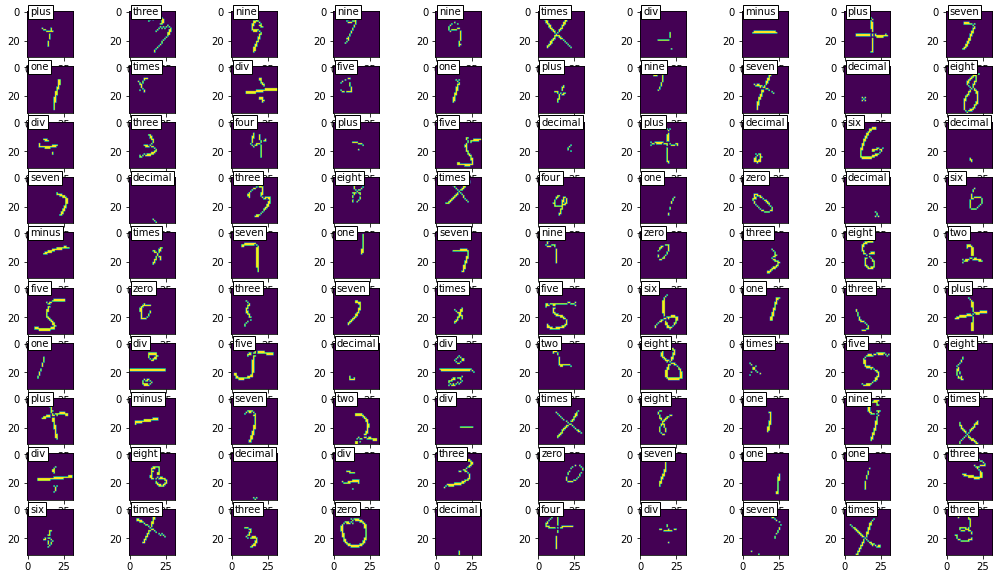

In [545]:
import math
from tqdm import tqdm
plt.rcParams['figure.figsize'] = [18, 10]

def show_grid(images, labels, width, dataset):
    f, axarr = plt.subplots(math.ceil(len(labels)/width), width)
    row, col = 0, 0
    for i, image in tqdm(enumerate(images)):
        label = dataset.idx_to_class[int(labels[i])]
        axarr[row,col].imshow(np.transpose(image, (1, 2, 0)))
        axarr[row,col].text(2, 2, label , bbox={'facecolor': 'white', 'pad': 2})
        col+=1
        if(col%width == 0):
            row+=1
            col = 0
    plt.show()
    
    
def show_transformed_images(dataset, name='', save=False, batch_size=100):
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,  shuffle=True) 
    batch = next(iter(loader))
    images, labels, original_imgs = batch
    if not os.path.isdir(f'./../data/aug/{name}'):
        os.mkdir(f'./../data/aug/{name}/')
    if save:
        for i in tqdm(range(len(images))):
            o_i_s_h, o_i_s_w = original_imgs[i].shape
            i_h, i_w = images[i][0].shape
            r_i = np.pad(images[i][0].numpy(), ((0, o_i_s_h - i_h), (0, 0)), 'constant', constant_values=-1)
            con_img = cv2.hconcat([original_imgs[i].numpy(), r_i])
            status = cv2.imwrite(f'./../data/aug/{name}/img_{str(i)}.png', con_img)
            
    width = 10
    show_grid(images, labels, width, dataset)
#     show_grid(original_imgs, labels, width, dataset)
show_transformed_images(train_dataset, batch_size=100, name='train', save=True)

# Eval Augmentation

In [546]:
eval_dataset_transform = A.Compose([
    ToBlackAndWhite(p=1),
    A.Resize(width=model_input_shape[0], height=model_input_shape[0]),
    Thresholding(p=1),
    Skeletonize(p=1,conv_shape=3),
    Thresholding(p=1),
    ToTensorV2()
])

In [547]:
eval_dataset = ImageDataset(root=eval_dataset_path, transform=eval_dataset_transform)

In [548]:
eval_dataset.class_to_idx

{'eight': 0,
 'decimal val': 1,
 'nine': 2,
 'times val': 3,
 'minus val': 4,
 'three': 5,
 'equal val': 6,
 'one': 7,
 'zero': 8,
 'seven': 9,
 'div val': 10,
 'two': 11,
 'six': 12,
 'plus val': 13,
 'five': 14,
 'four': 15}

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1703.20it/s]
100it [00:00, 715.31it/s]


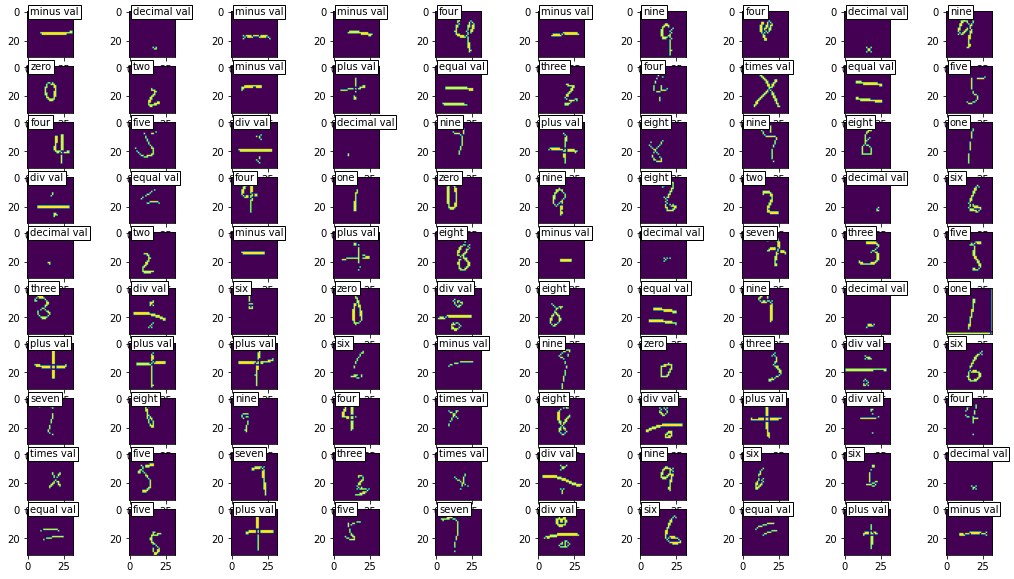

In [543]:
show_transformed_images(eval_dataset, save=True, name='eval', batch_size=100)

    # Test Data

In [549]:
test_dataset_transform = A.Compose([
    ToBlackAndWhite(p=1),
    A.Resize(width=model_input_shape[0], height=model_input_shape[0]),
    Thresholding(p=1),
    Skeletonize(p=1,conv_shape=3, invert=False),
    Thresholding(p=1),
    ToTensorV2()
])

test_dataset = ImageDataset(root=test_dataset_path, transform=test_dataset_transform)

In [550]:
show_transformed_images(test_dataset, save=True, name='test')

error: OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/core/src/copy.cpp:1026: error: (-215:Assertion failed) top >= 0 && bottom >= 0 && left >= 0 && right >= 0 && _src.dims() <= 2 in function 'copyMakeBorder'


# Crohm Dataset by Classes

In [551]:
crohm_dataset_transform = A.Compose([
    ToBlackAndWhite(p=1),
    A.Resize(width=50, height=50),
    A.Perspective(
        scale=(0.08, 0.12),
        p=0.5,
        fit_output=True,
        pad_val=(1.0),
    ),
    Dilation(p=0.5),
    Erosin(p=0.5),
    A.Rotate(limit=20, p=0.5, value=(1.0), border_mode=cv2.BORDER_CONSTANT),
    A.Resize(width=model_input_shape[0], height=model_input_shape[1]),
    A.PadIfNeeded(
        min_width=model_input_shape[0]+6,
        min_height=model_input_shape[1]+6,
        value=(1.0),
        border_mode=cv2.BORDER_CONSTANT,
        p=1
    ),
    A.RandomCrop(model_input_shape[0], model_input_shape[1]),
    ToTensorV2()
])

In [574]:
crohm_dataset = ImageDataset(root=crohme_dataset_path, transform=train_dataset_transform)

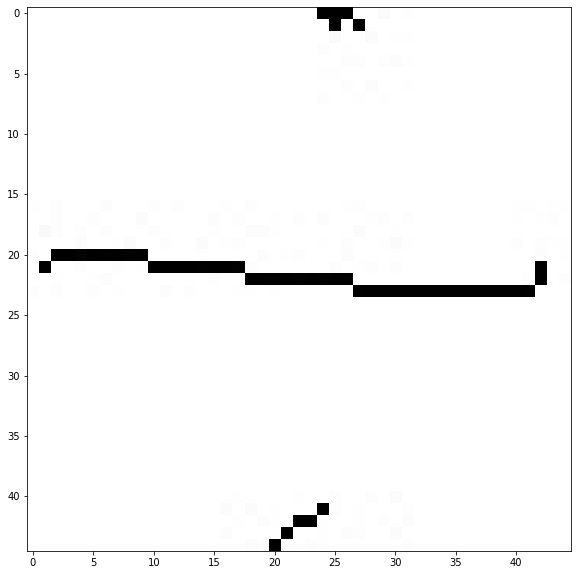

In [591]:
plt.imshow(crohm_dataset[0][2])

[[0 1 0]
 [1 1 1]
 [0 1 0]]


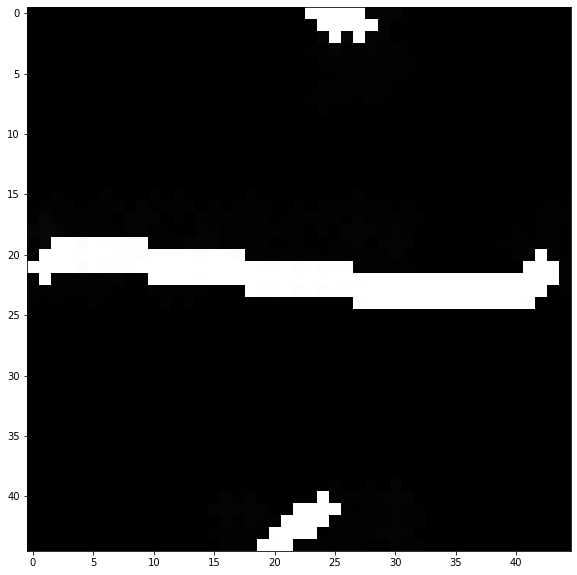

In [602]:
class Dilation(ImageOnlyTransform):
    def apply(self, img, **params):
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(3, 4, 2)))
        print(kernel)
        img = cv2.dilate(img, kernel, iterations=1)
        return img
img = crohm_dataset[0][2]
img = 255 - img
plt.imshow(Dilation(p=1)(image=img)['image'])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1920.20it/s]
100it [00:00, 704.99it/s]


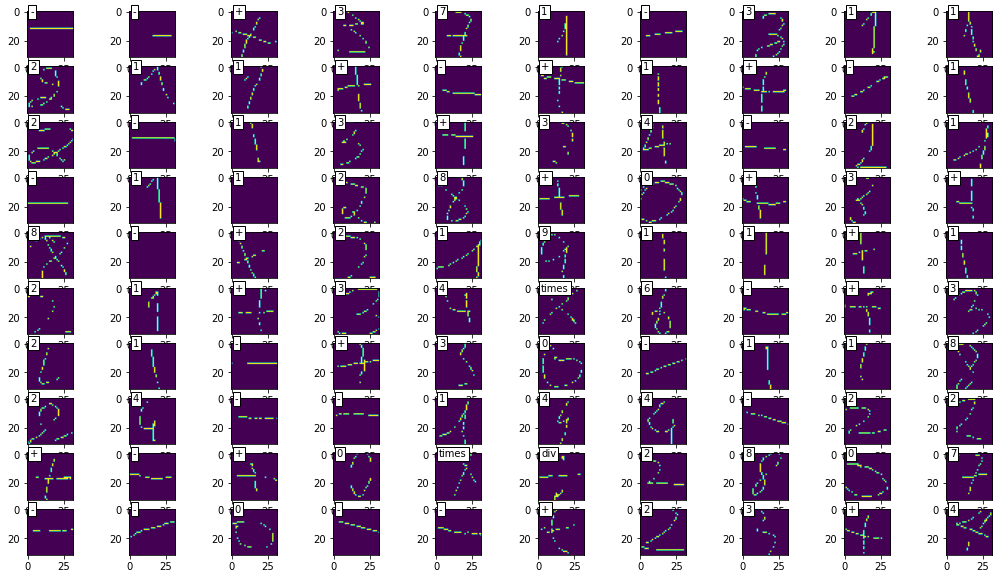

In [553]:
show_transformed_images(crohm_dataset, save=True, name='crohm')

'<__main__.ImageDataset object at 0x7f8afc8701f0>'